## Knowledge Graph

In [1]:
import pandas as pd
import spacy
import networkx as nx
from spacy.matcher import Matcher 


import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
pipeline = spacy.load('en_core_web_sm')

In [3]:
candidate_sentences = pd.read_csv("../input/wiki-sentences/wiki_sentences_v2.csv")
candidate_sentences.head()

,sentence
0,"confused and frustrated, connie decides to lea..."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


### Extract entities

In [4]:
def get_entities(sentence):
    ent1 = ""
    ent2 = ""

    prev_tok_dep = ""  # dependency tag of previous token in the sentence
    prev_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""


    for token in pipeline(sentence):
        
        # if token is a punctuation mark then move on to the next token
        if token.dep_ != "punct":
            # check: token is a compound word or not
            if token.dep_ == "compound":
                prefix = token.text
                # if the previous word was also a 'compound' then add the current word to it
                if prev_tok_dep == "compound":
                    prefix = prev_tok_text + " " + token.text

            # check: token is a modifier or not
            if token.dep_.endswith("mod"):
                modifier = token.text
                # if the previous word was also a 'compound' then add the current word to it
                if prev_tok_dep == "compound":
                    modifier = prev_tok_text + " " + token.text

            if token.dep_.find("subj"):
                ent1 = modifier + " " + prefix + " " + token.text
                prefix = ""
                modifier = ""
                prev_tok_dep = ""
                prev_tok_text = ""

            if token.dep_.find("obj"):
                ent2 = modifier + " " + prefix + " " + token.text

            # update variables
            prev_tok_dep = token.dep_
            prev_tok_text = token.text

    return [ent1.strip(), ent2.strip()]

In [5]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [6]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:31<00:00, 135.65it/s]


### Extract relations

In [7]:
def get_relation(sentence):

    doc = pipeline(sentence)

    # Matcher class object 
    matcher = Matcher(pipeline.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1",  [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [8]:
get_relation("John completed the task")


'completed'

In [9]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:34<00:00, 126.59it/s]


### Build knowledge graph


In [10]:
head = [i[0] for i in entity_pairs]
tail = [i[1] for i in entity_pairs]

knowledge_graph = pd.DataFrame({'head':head, 'tail':tail, 'relation':relations})
knowledge_graph.head()

,head,tail,relation
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with


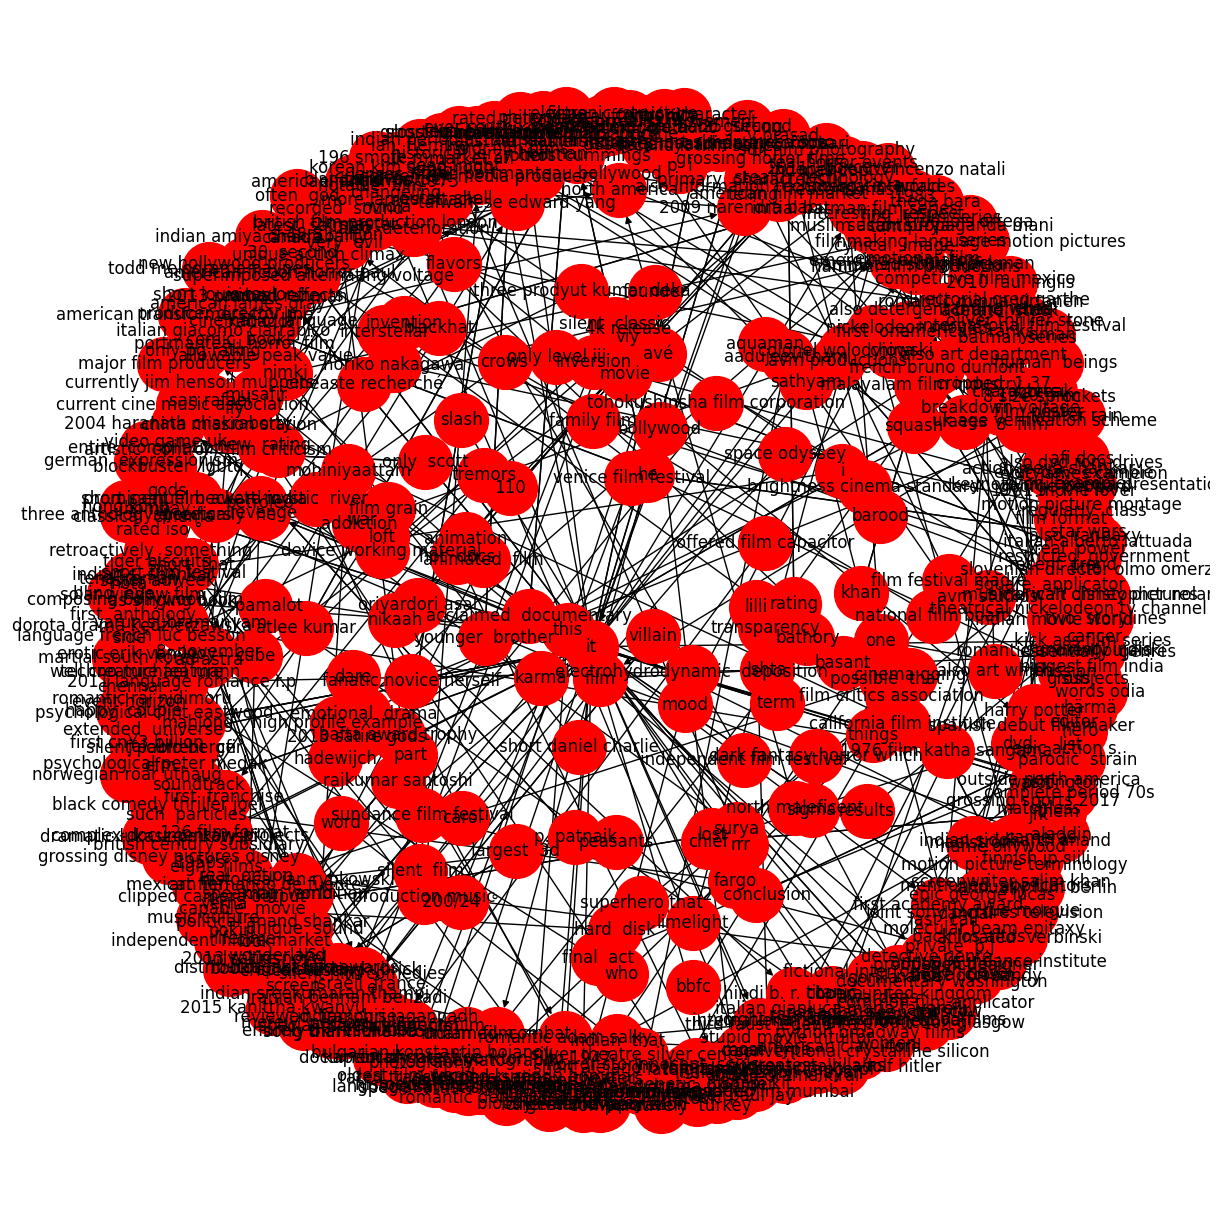

In [11]:
G=nx.from_pandas_edgelist(knowledge_graph[knowledge_graph['relation']=="is"], "head", "tail", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

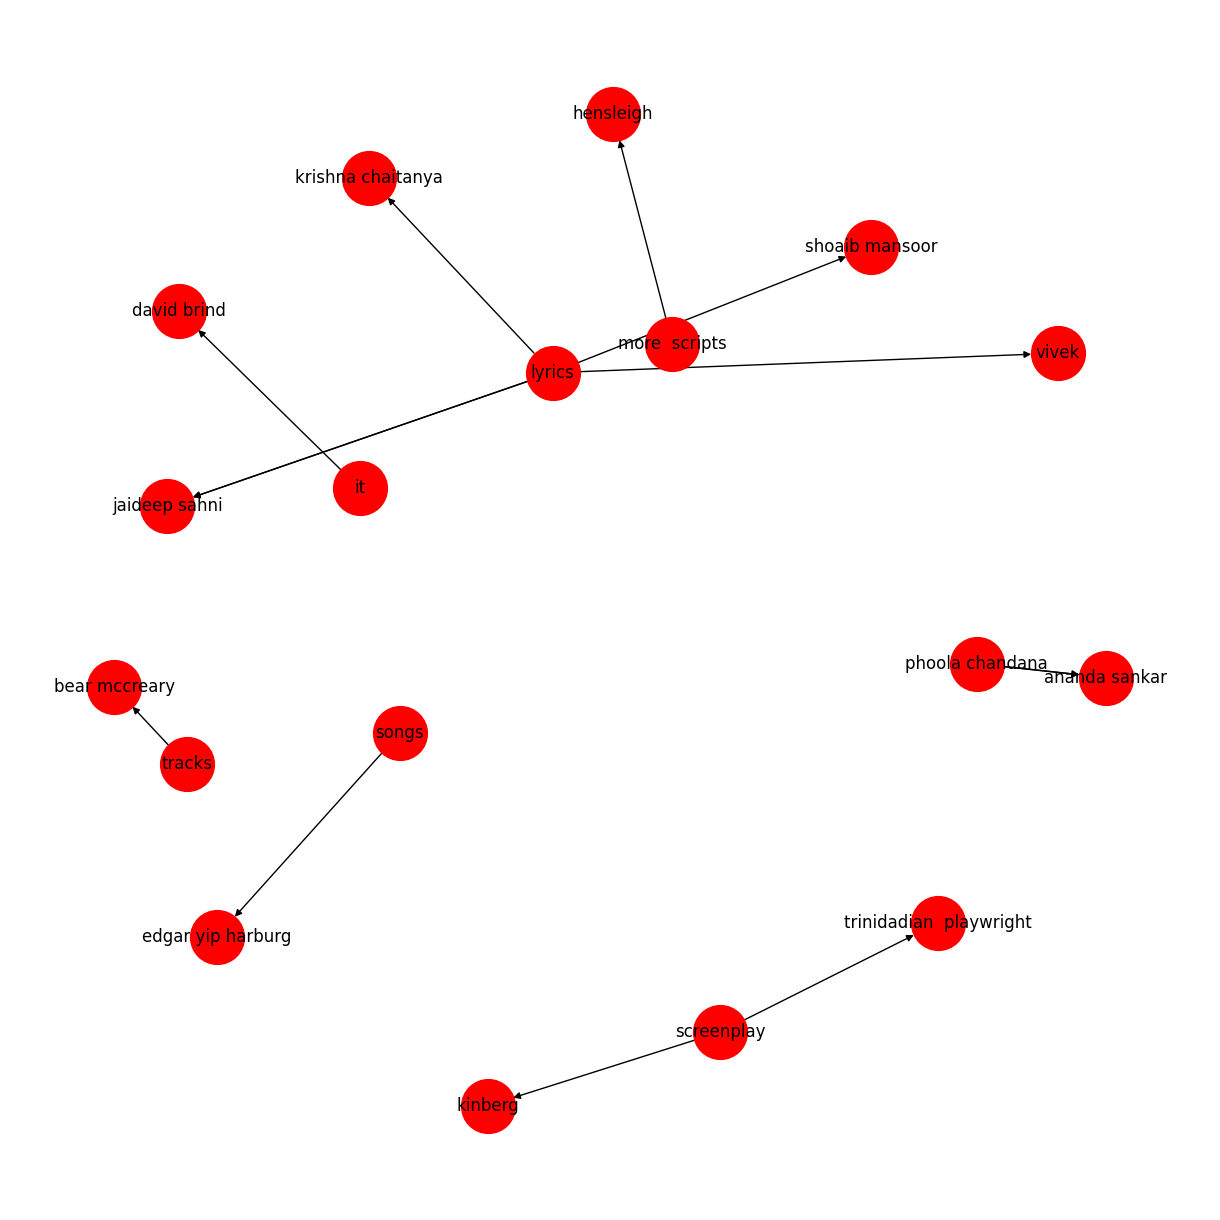

In [12]:
G=nx.from_pandas_edgelist(knowledge_graph[knowledge_graph['relation']=="written by"], "head", "tail", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Knowledge graph embeddings


In [13]:
%%capture
!pip install pykeen

In [14]:
from pykeen.pipeline import pipeline
import matplotlib.pyplot as plt

In [ ]:
result = pipeline(
    dataset="Nations",
    model="PairRE",
    # Training configuration
    training_kwargs=dict(
        num_epochs=10,
        use_tqdm_batch=False,
    ),
    # Runtime configuration
    random_seed=0,
)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):


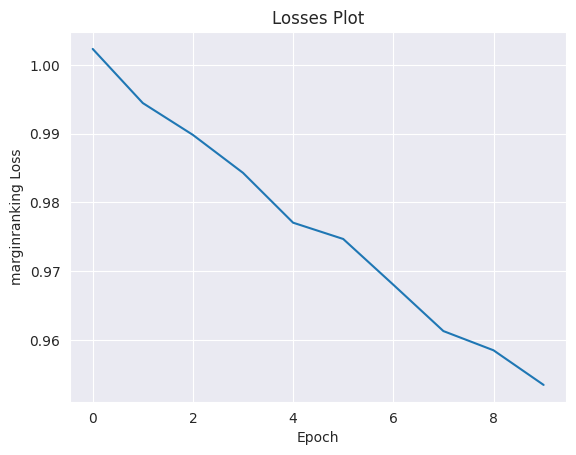

In [16]:
result.plot_losses()
plt.show()

In [17]:
print(f"Hits@5: {result.get_metric('hits@5')}")

Hits@5: 0.900497512437811


## Task

Task is to predict link between nodes in given knowledge graph.

In [18]:
import pandas as pd
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target

import warnings
warnings.filterwarnings('ignore')

In [19]:
df_train = pd.read_csv('train.txt', sep='\t',names=['head', 'relation', 'tail'])
df_train.head()

,head,relation,tail
0,Andrei_Tarkovsky,birthPlace,Soviet_Union
1,Ayn_Rand,citizenship,Soviet_Union
2,Albert_Einstein,deathPlace,"Princeton,_New_Jersey"
3,Albert_Einstein,award,Nobel_Prize_in_Physics
4,Amsterdam,part,Amsterdam-Zuid


In [20]:
df_val = pd.read_csv('valid.txt', sep='\t',names=['head', 'relation', 'tail'])
df_val.head()

,head,relation,tail
0,Charles_K._Kao,residence,Republic_of_China_(1912–49)
1,Starting_Over_(Raspberries_album),recordedIn,Record_Plant
2,Daniel_Mąka,birthPlace,Poland
3,Ox_(band),bandMember,Ryan_Bishops
4,Tiger_Jones_(American_football),birthPlace,"Mobile,_Alabama"


In [21]:
train = TriplesFactory.from_labeled_triples(df_train[['head', 'relation', 'tail']].values)
val = TriplesFactory.from_labeled_triples(df_val[['head', 'relation', 'tail']].values,
                                             entity_to_id=train.entity_to_id,relation_to_id=train.relation_to_id,)


In [ ]:
result = pipeline(
    training=train,
    validation=val,
    testing=val,
    model="TransE",
    loss="focal",
    model_kwargs=dict(embedding_dim=64),
    training_kwargs=dict(num_epochs=50, use_tqdm_batch=False),
    random_seed=1,
)

In [23]:
print(f"Hits@5: {result.get_metric('hits@5')}")

Hits@5: 0.42276422764227645


In [24]:
df_test = pd.read_csv('test.txt', sep='\t',names=['head', 'tail'])
df_test.head()

,head,tail
0,James_C._Gardner,United_Methodist_Church
1,Myrmecophila_humboldtii,Epidendroideae
2,Roy_Jordan,Newport_County_A.F.C.
3,Greta_Kuckhoff,Germany
4,Sunset_People,Synthpop


In [25]:
y_true = []
y_pred = []
res = []
for i, row in df_test.iterrows():
    head = row['head']
    tail = row['tail']
    prediction = predict_target(result.model, head=head, tail=tail, triples_factory=result.training).df
    p = int(prediction.iloc[0]['relation_id'])
    res.append(' '.join(result.training.relation_id_to_label[int(prediction.iloc[i]['relation_id'])] for i in range(5)))

In [26]:
df_submission = pd.DataFrame(res, columns=['relation'])
df_submission.head()

,relation
0,religion doctoralAdvisor designer designCompan...
1,family neighboringMunicipality successor forme...
2,team managerClub tenant owner routeEnd
3,foundationPlace country restingPlace hometown ...
4,genre programmeFormat stylisticOrigin literary...
